# DiD Analysis

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.15e-30
Time:                        16:32:26   Log-Likelihood:                -1087.8
No. Observations:                  84   AIC:                             2184.
Df Residuals:                      80   BIC:                             2193.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.223e+05    1.9e+04     27.427

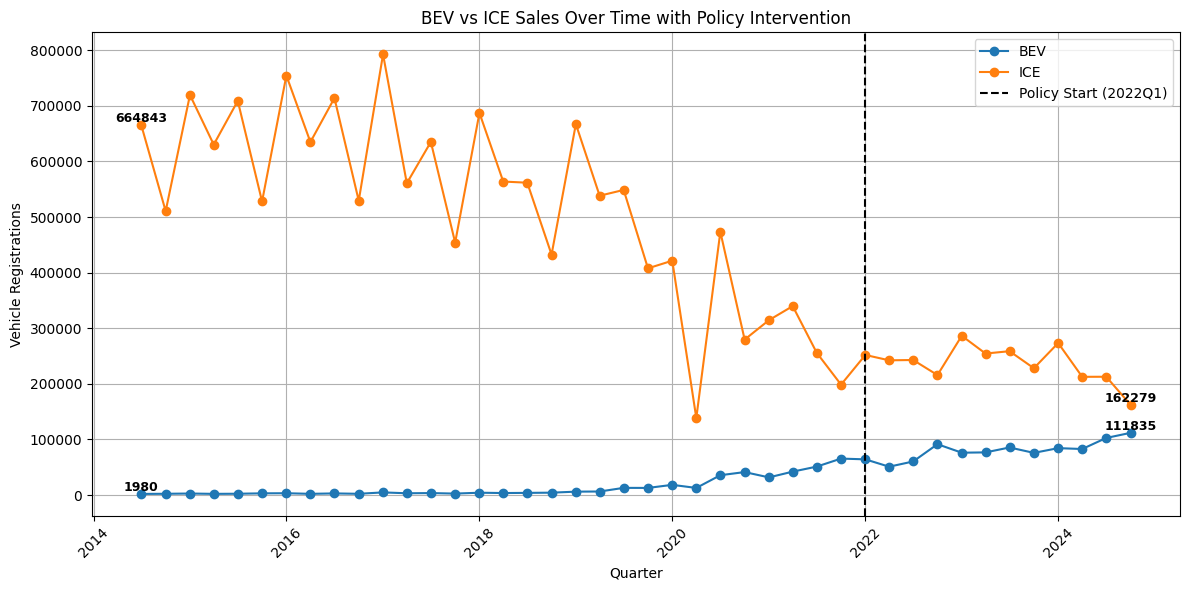

In [1]:
import pandas as pd 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv("DiD_Dataset.csv")

df['Quarter_Date'] = pd.PeriodIndex(df['Quarter'], freq='Q').to_timestamp()

#DiD regression
model = smf.ols("Sales ~ Treated_Group + Post_Policy + DiD", data=df).fit()

print(model.summary())

plt.figure(figsize=(12,6))
for fuel in ['BEV', 'ICE']:
    sub = df[df['Fuel_Type'] == fuel].sort_values('Quarter_Date')
    plt.plot(sub['Quarter_Date'], sub['Sales'], label=fuel, marker='o')
    
    #first and last data points
    for i in [0, -1]: 
        x = sub['Quarter_Date'].iloc[i]
        y = sub['Sales'].iloc[i]
        plt.text(x, y, f'{y}', fontsize=9, ha='center', va='bottom', fontweight='bold')

plt.axvline(pd.to_datetime('2022-01-01'), color='black', linestyle='--', label='Policy Start (2022Q1)')
plt.title('BEV vs ICE Sales Over Time with Policy Intervention')
plt.xlabel('Quarter')
plt.ylabel('Vehicle Registrations')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()


# Parallel trends check

In [2]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv("DiD_Dataset.csv")

df['Quarter_Date'] = pd.PeriodIndex(df['Quarter'], freq='Q').to_timestamp()

pre_policy_df = df[df['Quarter_Date'] < '2022-01-01'].copy()

pre_policy_df = pre_policy_df.sort_values('Quarter_Date')
pre_policy_df['Time'] = pre_policy_df.groupby('Fuel_Type').cumcount()

# Running regression with interaction to test for parallel trends
model_pretrend = smf.ols("Sales ~ Treated_Group * Time", data=pre_policy_df).fit()

print(model_pretrend.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.926
Model:                            OLS   Adj. R-squared:                  0.922
Method:                 Least Squares   F-statistic:                     234.5
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.15e-31
Time:                        16:32:27   Log-Likelihood:                -759.73
No. Observations:                  60   AIC:                             1527.
Df Residuals:                      56   BIC:                             1536.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           7.385e+05   2.82

# DiD Analysis with charger statistics

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.632
Method:                 Least Squares   F-statistic:                     19.87
Date:                Sun, 14 Sep 2025   Prob (F-statistic):            0.00122
Time:                        16:32:27   Log-Likelihood:                -126.94
No. Observations:                  12   AIC:                             257.9
Df Residuals:                      10   BIC:                             258.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.71

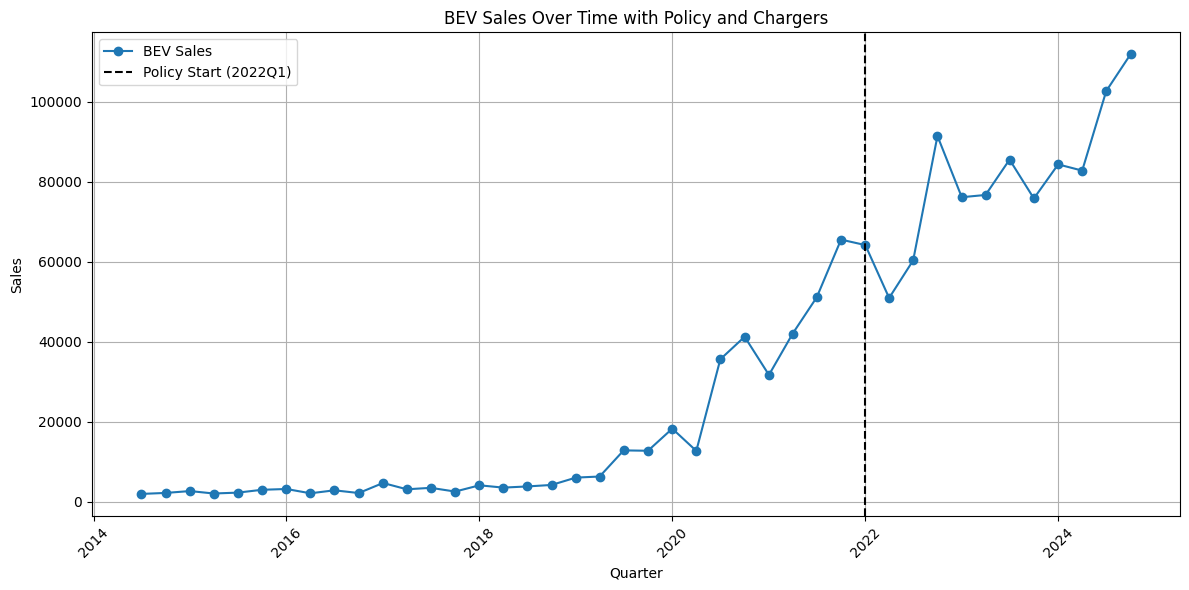

In [3]:
import pandas as pd
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

df = pd.read_csv("BEV_DiD_with_Chargers.csv")

df['Quarter_Date'] = pd.PeriodIndex(df['Quarter'], freq='Q').to_timestamp()

#regression with charger interaction
model = smf.ols("Sales ~ Post_Policy + Total_Charging_Devices + charger_x_post + C(Fuel_Type)", data=df).fit()

print(model.summary())

plt.figure(figsize=(12, 6))
bev = df[df['Fuel_Type'] == 'BEV']
plt.plot(bev['Quarter_Date'], bev['Sales'], marker='o', label='BEV Sales')
plt.axvline(pd.to_datetime("2022-01-01"), color='black', linestyle='--', label='Policy Start (2022Q1)')
plt.title("BEV Sales Over Time with Policy and Chargers")
plt.xlabel("Quarter")
plt.ylabel("Sales")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


# DiD Estimation using Matched Dataset

In [4]:
#Install only if not installed previously
#pip install pandas numpy statsmodels scikit-learn


In [5]:
import pandas as pd
df = pd.read_csv("DiD_Dataset.csv")
df.head()


,Quarter,Sales,Fuel_Type,Treated_Group,Post_Policy,DiD
0,2014Q3,1980,BEV,1,0,0
1,2014Q3,664843,ICE,0,0,0
2,2014Q4,510710,ICE,0,0,0
3,2014Q4,2228,BEV,1,0,0
4,2015Q1,2693,BEV,1,0,0


In [6]:
df_pre = df[df['Post_Policy'] == False].copy()

# Selecting relevant covariates
covariates = ['Sales'] 

df_pre['Treated'] = df_pre['Treated_Group'].astype(int)

In [7]:
from sklearn.linear_model import LogisticRegression

X = df_pre[covariates]
y = df_pre['Treated']

logit = LogisticRegression()
logit.fit(X, y)

df_pre['propensity_score'] = logit.predict_proba(X)[:, 1]


In [8]:
from sklearn.neighbors import NearestNeighbors
import numpy as np


treated = df_pre[df_pre['Treated'] == 1]
control = df_pre[df_pre['Treated'] == 0]


nn = NearestNeighbors(n_neighbors=3)
nn.fit(control[['propensity_score']])

# Matching each treated unit
distances, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()]

matched_df = pd.concat([treated, matched_control], axis=0).reset_index(drop=True)


In [9]:
final_matched_df = df.merge(
    matched_df[['Fuel_Type']].drop_duplicates(),
    on='Fuel_Type',
    how='inner'
)

print("\nFinal matched data stats (Pre + Post):")
print(final_matched_df.groupby(['Post_Policy', 'Treated_Group'])['Sales'].describe())



Final matched data stats (Pre + Post):
                           count           mean            std       min  \
Post_Policy Treated_Group                                                  
0           0               30.0  522279.433333  170824.185245  138424.0   
            1               30.0   13024.566667   17262.938515    1980.0   
1           0               12.0  236812.583333   33202.753836  162279.0   
            1               12.0   80218.000000   17159.511553   50946.0   

                                 25%       50%        75%       max  
Post_Policy Treated_Group                                            
0           0              424285.25  543597.0  657424.50  792791.0  
            1                2740.00    3989.5   12835.25   65529.0  
1           0              215035.75  242599.5  255551.00  286422.0  
            1               72900.75   79729.5   86999.75  111835.0  


In [10]:
import statsmodels.formula.api as smf

#DiD model
model = smf.ols('Sales ~ Treated_Group + Post_Policy + DiD', data=final_matched_df).fit()

print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.830
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     130.0
Date:                Sun, 14 Sep 2025   Prob (F-statistic):           1.15e-30
Time:                        16:32:28   Log-Likelihood:                -1087.8
No. Observations:                  84   AIC:                             2184.
Df Residuals:                      80   BIC:                             2193.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.223e+05    1.9e+04     27.427

# Group Bar Chart of Mean Sales

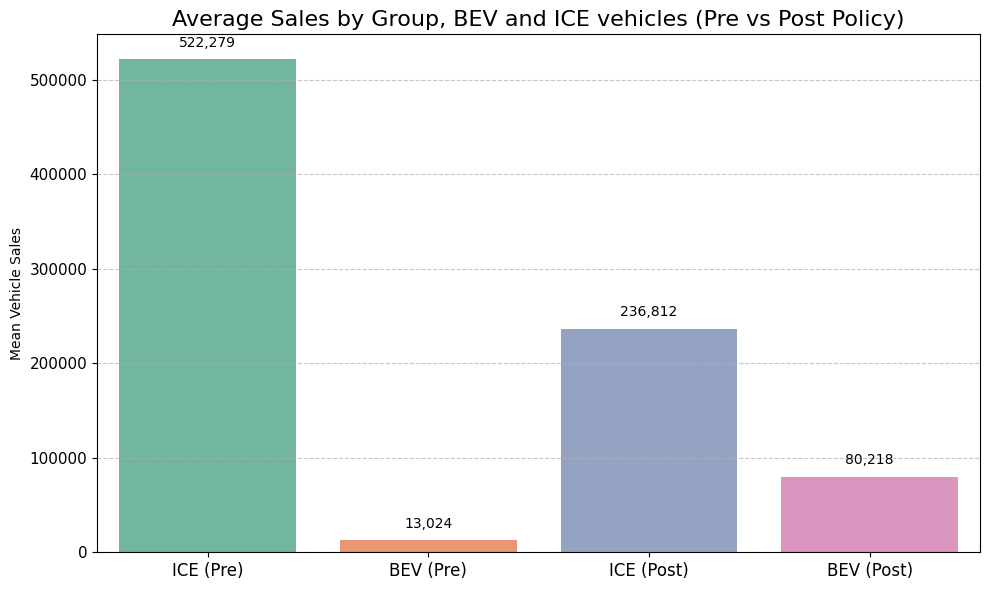

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

df_means = (
    final_matched_df
    .groupby(['Post_Policy', 'Treated_Group'])['Sales']
    .mean()
    .reset_index()
)

df_means['Group'] = df_means.apply(lambda row: 
    'ICE (Pre)' if row['Post_Policy'] == 0 and row['Treated_Group'] == 0 else
    'BEV (Pre)' if row['Post_Policy'] == 0 and row['Treated_Group'] == 1 else
    'ICE (Post)' if row['Post_Policy'] == 1 and row['Treated_Group'] == 0 else
    'BEV (Post)', axis=1
)

plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Sales', hue='Group', data=df_means, 
            palette='Set2', dodge=False, legend=False)

plt.title('Average Sales by Group, BEV and ICE vehicles (Pre vs Post Policy)', fontsize=16)
plt.ylabel('Mean Vehicle Sales')
plt.xlabel('')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=11)

for index, row in df_means.iterrows():
    plt.text(index, row['Sales'] + 10000, f"{int(row['Sales']):,}", 
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()
